<center>
    <h1 style="font-size: 12; font-weight: 900; ">--- 5 ---<h1>
    <h2>CSiAPI - ETABS y SAP2000</h2>
    <!-- <p><strong></strong</p> -->
</center>

# Marco Parametrico (Frame 2D)

In [49]:
import os, sys
import comtypes.client

In [50]:
import numpy as np

## 1. Uso de sistema de Unidades

In [51]:
# Unidades Base mks
m = 1
kg = 1
s = 1

# Otras Unidades
cm = 0.01*m
kgf = 9.80665*kg*m/s**2
tonf = 1000*kgf

# Constantes Físicas
g = 9.80665*m/s**2

# configuraciones de unidades
kN_m_C = 6
kgf_m_C = 8
Tonf_m_C = 12

## 2. Propiedades, materiales y geometria o modelo

### Ejemplo-01

Analizar completamente la estructura mostrada. Considerar que el marco es de concreto armado donde E = 217370.65 kg/cm2 y las propiedades geométricas de los elementos estructurales son para vigas: 25 × 50 cm2 y para columnas: 25 × 25 cm2. La zapata en el apoyo izquierdo
es de 80 × 80 cm2 y en el apoyo derecho es de 100 × 100 cm2.

<center>

![e-02](./images/e2.png)

</center>

Nota: El presente ejercicio es resuelto en el PROBLEMA 10-10 con simulación de apoyo elástico. ref (Alder Jhosue Quispe Panca)

In [ ]:
fc = 210 * (kg/cm**2)   # Concrete strength [kg/cm2]
# E = 151 * fc **0.5 *(kgf/cm**2)
E = 217370.65 *(kg/cm**2)
v = 0.2
G = 0.5 *E / (1+v) # Shear modulus [kgf/cm**2]
coeficienteTermico = 0

material_type = 2;
material_name = f'fc={str(fc)} kg/cm^2'; # fc=280kg/cm^2

# --- secciones para la viga y columna
secBeamb = 25*cm # cm
secBeamh = 50*cm # cm
beamName = f'V{str(secBeamb)}x{str(secBeamh)}'
secColumnb = 25*cm # cm
secColumnh = 25*cm # cm
columnName = f'C{str(secColumnb)}x{str(secColumnh)}'

coords = np.array([
    [0.0, 0.0, 0.0],
    [5.0, 0.0, 0.0],
    [0.0, 0.0, 4.0],
    [5.0, 0.0, 4.0],
    [0.0, 0.0, 7.0],
    [5.0, 0.0, 7.0],
]);
elems = np.array([
    [0, 2, 1], # columna=1
    [1, 3, 1], # columna
    [2, 3, 2], # viga=2
    [2, 4, 1], # columna
    [3, 5, 1], # columna
    [4, 5, 2], # viga
]);

apoyos = np.array([
    [0, True, True, True, True, True, True],
    [1, True, True, True, True, True, True],
]);

# cargas puntuales
NameLoadP, LTYPE = "CPuntual", 8 # LTYPE_OTHER=8
#   cargasEnNodo[idNodo, Fx, Fy, Fz, Rx, Ry, Rz]
cargasEnNodo = np.array([
    [2, 700, 0.0, 0.0, 0.0, 0.0, 0.0],
    [5, 1_000, 0.0, 0.0, 0.0, 0.0, 0.0],
])

DName, LName = "CMuerta", "CViva"
# cargas distribuidas
#   cargasDistr[idElem, node_i, node_j, F/L, [1:g,2:r,3:b], i, j, tipoCarga, node_i, node_j, F/L, [1:g,2:r,3:b], i, j, tipoCarga]
cargasDistr = np.array([
    [2, -0.4, -0.4, 1, 2, 0, 1, "Dead", -0.4, -0.4, 1, 2, 0, 1, "Live"],
    [5, -0.4, -0.4, 1, 2, 0, 1, "Dead", -0.25, -0.25, 1, 2, 0, 1, "Live"],
])

nameModelProject = 'Marco de 2 Niveles Regular (2D)'
# Coneccion: 1 para sap2000 y 2 para etabs
connect_to = 1;

# Variable para definir una instancia manual para el programa y definir la ruta.
rutaEspecifica = False
if rutaEspecifica:
    ruta_app = "C:\\Program Files\\Computers and Structures\\SAP2000 23\\SAP2000.exe" if connect_to else "C:\\Program Files\\Computers and Structures\\ETABS 21\\ETABS.exe"
else: 
    ruta_app = None

### Ejemplo-02

## 3. Coneccion

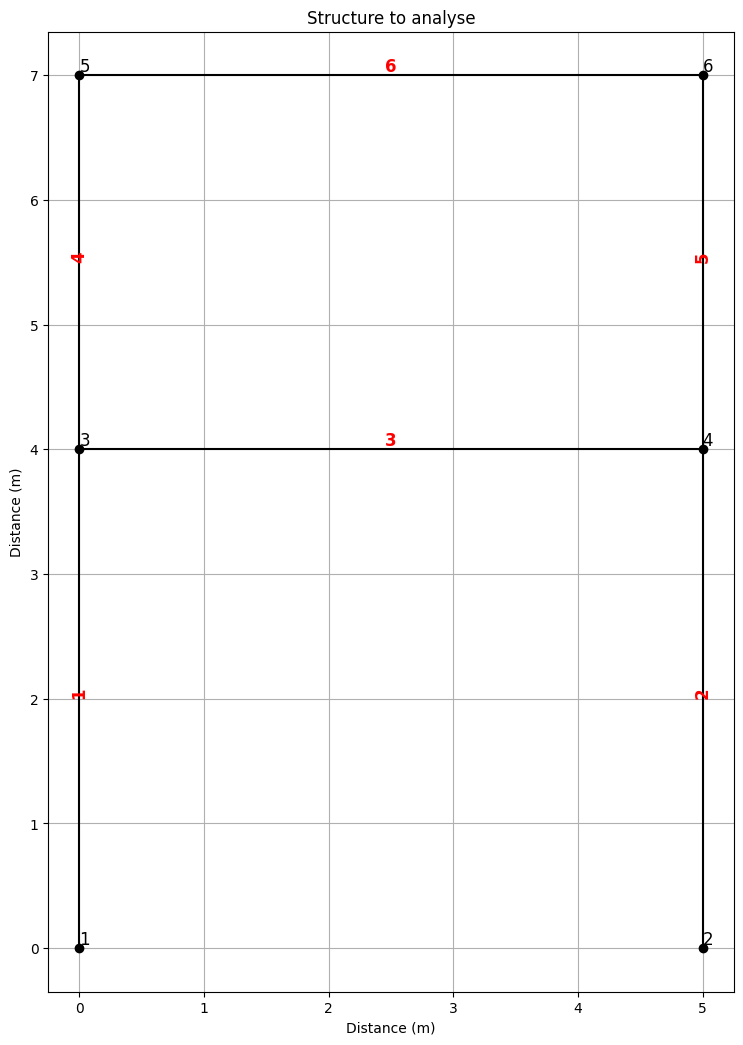

In [53]:
from utilities.plotModel import plotModel2d, plotModel3d

plotModel2d(coords, elems, nameModelProject)

In [54]:
from utilities.connectcsi import ConnectCSiAPI

In [55]:
smodel, response = None, None

connection = ConnectCSiAPI(connect_to)
response, connect_to_app = connection.connect_default()

SAP2000
Coneccion establecida para SAP2000!.


In [56]:
connect_to_app.ApplicationStart()

smodel = connect_to_app.SapModel

## 4. Se crea un nuevo Lienzo y Modelo

In [57]:
smodel.SetModelIsLocked(False)

0

In [58]:
# ------------------- creacion de nuevo modelo ------------------

# Se crea un nuevo lienzo
# smodel.InitializeNewModel; # esto es valido tambien
smodel.InitializeNewModel(Tonf_m_C)
print(smodel.GetPresentUnits())

if connect_to == 2:
    # create grid-only template model | Crea una nueva hoja con grilla
    response_status = smodel.File.NewGridOnly(3, 3*m,3*m, 5*m,4*m, 4*m,4*m)
else:
    response_status = smodel.File.NewBlank()

response_status

12


0

In [59]:
# Unit Preferences | Preferencias de Sistema de Unidades
# .... en la parte de unidades se define las medidadas ...
smodel.SetPresentUnits(kN_m_C)

# get present units | Optener la presente unidad(s)
print(smodel.GetPresentUnits())

6


In [60]:
smodel.View.RefreshView(0, False);

## 5. Se establece las propiedades del concreto

In [61]:
# definicion del material
response_status = smodel.PropMaterial.SetMaterial( material_name, material_type )
# propiedades mecanicas del material
response_status = smodel.PropMaterial.SetMPIsotropic( 
    material_name, 
    E, 
    v, 
    coeficienteTermico 
    )
display(response_status)

0

In [62]:
# Secciones de viga y columna
response_status = smodel.PropFrame.SetRectangle(beamName, material_name, secBeamb, secBeamh) # seccion para la viga
response_status = smodel.PropFrame.SetRectangle(columnName, material_name, secColumnb, secColumnh) # seccion para la columna
display(response_status)

0

In [63]:
smodel.View.RefreshView(0, False);

## 6. Geometria de la estructura

In [64]:
# 2da forma de ingreso
FrameName1 = ''
mbrName = ''
for idx, mbr in enumerate(elems):
    deNodo = int(mbr[0])
    alNodo = int(mbr[1])
    identificador = int(mbr[2]) # columna o viga
    xi, yi, zi = coords[deNodo, 0], coords[deNodo, 1], coords[deNodo, 2]
    xf, yf, zf = coords[alNodo, 0], coords[alNodo, 1], coords[alNodo, 2]
    # columnas
    if identificador == 1: mbrName = columnName
    # vigas
    elif identificador == 2: mbrName = beamName
    else: pass
    [FrameName1, response_status] = smodel.FrameObj.AddByCoord(
        xi,yi,zi, xf,yf,zf, "FrameName"+str(idx+1), mbrName, str(idx+1), 'Global'
        # xi,yi,zi, xf,yf,zf, str(idx+1), mbrName, str(idx+1), 'Global'
    )
    display(response_status)

0

0

0

0

0

0

In [65]:
smodel.View.RefreshView(0, False);

In [66]:
# frameName, point1, point2, ret = "", "", "", ""
# [FrameName1, ret] = smodel.FrameObj.AddByCoord(0, 0, 0, 0, 0, 3, frameName);# True,"Defualt","","Global"
# [FrameName1, ret] = smodel.FrameObj.AddByCoord(6, 0, 0, 6, 0, 3, frameName);
# [FrameName1, ret] = smodel.FrameObj.AddByCoord(0, 0, 3, 6, 0, 3, frameName);

# restr = [True, True, True, True, True, True];
# smodel.Pointobj.SetRestraint(point1, restr);
# smodel.Pointobj.SetRestraint(point2, restr);

# lpName = "Test";
# # 1 = Force per unit length
# # 2 = Moment per unit length
# # smodel.FrameObj.SetLoadDistributed(FrameName, "DEAD", 1, 10, 0.0, 1.0, 15.0, 5.0);
# smodel.FrameObj.SetLoadDistributed(frameName, lpName, 1, 10, 0.0, 1.0, 15.0, 5.0);


## 7. Restricciones o condiciones de borde (apoyos)

In [73]:
nrestrict = apoyos.shape[0]
node_i, node_j = ' ', ' '
for node, restricts in enumerate(apoyos):
    [node_i, node_j, response_status1] = smodel.FrameObj.GetPoints(
        str(int(restricts[0])+1), 
        node_i, 
        node_j
        )
    response_status = smodel.Pointobj.SetRestraint(
        node_i, 
        [*apoyos[node,1::].tolist()]
        );
    
    print(response_status1, response_status, ["FrameName"+str(restricts[0]+1), apoyos[node,1::].tolist()])

0 [(True, True, True, True, True, True), 0] ['FrameName1', [1, 1, 1, 1, 1, 1]]
0 [(True, True, True, True, True, True), 0] ['FrameName2', [1, 1, 1, 1, 1, 1]]


In [74]:
smodel.View.RefreshView(0, False);

## 8. Se establece carga muertas y vivas (puntual, distribuida)

8.1 establecemos las unidades de las cargas

In [75]:
smodel.SetPresentUnits(kN_m_C) # configuracion de unidades para la carga
print(smodel.GetPresentUnits())

6


8.2 patron de carga

In [94]:
# eLoadPatternType
smodel.LoadPatterns.Add(NameLoadP, LTYPE, True) # patron para la cargas puntuales (Other=8)
smodel.LoadPatterns.Add(LName, 3) # patron para la carga distribuida viva (Live=3)
smodel.LoadPatterns.Add(DName, 1) # patron para la carga muerta (Dead=1)

1

8.3 Asignamos la carga

In [95]:
#  --- cargas en nodos ---
# altura_entrepiso = [2.5, 2.5, 3]
# altura_acumulada = [sum(altura_entrepiso[:i]) for i in range(len(altura_entrepiso)+1)]
# Colimna_i = [[(0,0,i), f'col_i_{i}'] for i in altura_acumulada]
# for a,b in zip(Colimna_i, [0,5,10,12]):
#     print(a[1])

for _, carga_en_nudo in enumerate(cargasEnNodo):
    PointName1 = int(carga_en_nudo[0])
    node_load = carga_en_nudo[1:].tolist()
    response = smodel.PointObj.SetLoadForce(
        str(PointName1), 
        NameLoadP, 
        node_load
        )
    
    print( f"{node_load} estado = {response[1]}" )

[700.0, 0.0, 0.0, 0.0, 0.0, 0.0] estado = 0
[1000.0, 0.0, 0.0, 0.0, 0.0, 0.0] estado = 0


In [103]:
# --- cargas viva y muerta ---
FrameName4, FrameName5 = ' ',' '
for _, carga in enumerate(cargasDistr):
    PointName1 = int(carga[0])
    cmuerta, cviva = carga[1:7].tolist(), carga[8:-1].tolist()
    print(f"carga muerta: {cmuerta}, carga viva: {cviva}")
    
    # smodel.FrameObj.SetLoadPoint('carga_viva', 'LIVE', 1, 4, )
    # response_status = smodel.FrameObj.SetLoadDistributed(FrameName4, "Dead", 1, 2, 0,1, -0.4, -0.4, "Local");
    # response_status = smodel.FrameObj.SetLoadDistributed(FrameName5, "Live", 1, 2, 0,1, -0.25, -0.25, "Local");

# response_status

carga muerta: ['-0.4', '-0.4', '1', '2', '0', '1'], carga viva: ['-0.4', '-0.4', '1', '2', '0', '1']
carga muerta: ['-0.4', '-0.4', '1', '2', '0', '1'], carga viva: ['-0.25', '-0.25', '1', '2', '0', '1']


In [ ]:
# --- Cargas distribuidas ---


## 8. Guardamos el modelo

In [ ]:
# full path to the model, set it to the desired path of your model
APIPath = 'C:\\CSi_API_Example'
if not os.path.exists(APIPath):
    try: os.makedirs(APIPath)
    except OSError: pass
ModelPath = APIPath + os.sep + 'Frame3D.edb'

smodel.File.Save(ModelPath);

## 9. Ejecutar analisis

In [ ]:
# ------------------ Analisis y ejecucion del modelo -----------------
# # una ves ejecutado una primera vez ya se peude 
# # comentar de la linia 26 a 56 y descomentar 60 a 63
# smodel.SetModelIsLocked(false);
# for i in range(3):
#     smodel.FrameObj.SetEndLengthOffset(str(i), flase, 0.0, 0.0, 0.0);

# 'run analysis
smodel.Analyze.RunAnalysis();

## 10. Mostramos los resultados y Cerramos la coneccion o la aplicacion

In [ ]:
# 'deselect all cases and combos
ret = smodel.Results.Setup.DeselectAllCasesAndCombosForOutput();
# 'check if case is selected
ret = smodel.Results.Setup.SetCaseSelectedForOutput(lpName);

# 'get frame forces
name=""
eItemElm = 0
numberResults = 0;
obj = [];
objSta = [];
elm = [];
elmSta = [];
loadCase = [];
stepType = [];
stepNum = [];
p = [];
v2 = [];
v3 = [];
t = [];
m2 = [];
m3 = [];
[name, eItemElm, numberResults, 
    obj, objSta, elm, elmSta, loadCase, stepType, stepNum,
    p, v2, v3, t, m2] = smodel.Results.FrameForce("All", eItemElm, numberResults,
    obj, objSta, elm, elmSta, loadCase, stepType, stepNum,
    p, v2, v3, t, m2, m3);

# 
print("Mesage de salida\nmesnage1\tmensage2\tmensage3");
for i in range(ret[2]):
    print(f"{obj[i]}\t{[i]}\t{ret[15][i]}");


In [104]:
# Close the program | Cerrar la aplicacio
if(connect_to_app.ApplicationExit(False)): print("No se pudo cerrar la coneccion!")
else: print("Se cerro con exito.")
    
onnect_to_app, smodel = None, None
del (connect_to_app, smodel)

NameError: name 'connect_to_app' is not defined